# Testbed for Computing Metrics
Next cell contains code for retrieving the model and dataset.

In [26]:
import os
import metrics as mt
import matplotlib.pyplot as plt
import numpy as np

def get_metric_data(items=None):
    final_files = []
    for path,folders,files in os.walk("experiments/"):
        if path.endswith("mutual_info_sample") and "final.npz" in files:
            if not items is None:
                if items in path: final_files.append(os.path.join(path,"final.npz"))
            else:
                final_files.append(os.path.join(path,"final.npz"))
    model_data = {}
    for i,file in enumerate(final_files):
        data = np.load(file)
        model_data[i] = data["latents"], data["labels"], data["path"]
    return model_data

def get_set(model_num):
    model,path = mt.get_model(model_num=model_num, return_path=True, basepath=os.environ["HSR_MODEL_DIR"])
    sample_path = os.path.dirname(os.path.relpath(path, os.environ["HSR_MODEL_DIR"]))+"/"
    data = get_metric_data(sample_path)[0]
    dataset = mt.get_dataset(path)
    return model, dataset, data

model, dataset, data = get_set(model_num=1064)

 selected: /media/ychen/9e2eec28-a070-4a9f-b355-8d239ceb6631/projects_archive/hsr/models/lvae_larger2/hiershapes/boxhead_07/base/num_latents_4/base/gamma_1/beta_1_annealed/alpha_scheduled/random_seed_1/model 


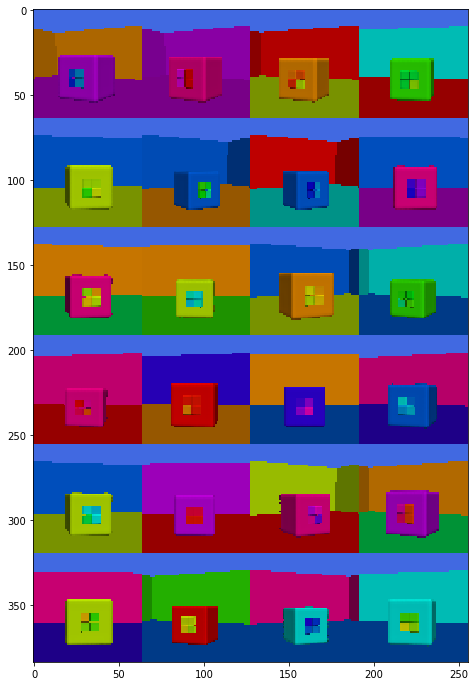

In [33]:
plt.rcParams["figure.figsize"]=8,12
dset = dataset.train(64)
for images, labels in dset:
    images = images[:4*6]
    images = images.reshape(4,6,64,64,3)
    images = np.concatenate(images, -2)
    images = np.concatenate(images, -3)
    plt.imshow(images)
    break

## Measure DCI Metrics On Data
all code in the cell below is adapted from [disentanglementlib's DCI](https://github.com/google-research/disentanglement_lib/blob/master/disentanglement_lib/evaluation/metrics/dci.py)

Run the cell below to evaluate DCI on a single model


### Model 1064
result for /media/ychen/9e2eec28-a070-4a9f-b355-8d239ceb6631/projects_archive/hsr/models/lvae_larger2/hiershapes/boxhead_07/base/num_latents_4/base/gamma_1/beta_1_annealed/alpha_scheduled/random_seed_1/model:


num_bins=20 for histogram discretize

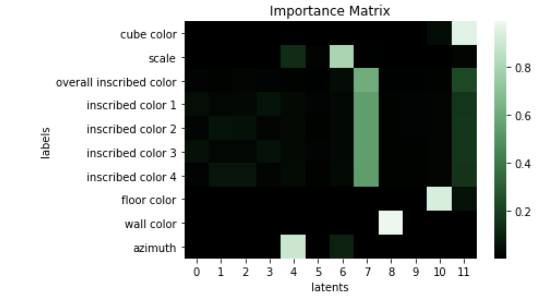

num_bins=40 for histogram discretize

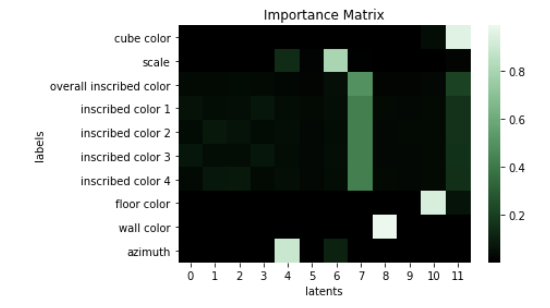

In [2]:
import numpy as np
import scipy
from six.moves import range
from sklearn import ensemble, preprocessing
import gin.tf
import seaborn as sns

class DCI:
    def get_trained_gbts(self, latents, labels):
        num_codes, num_factors = latents.shape[-1], labels.shape[-1]
        importance_matrix = np.zeros(shape=[num_codes, num_factors])
        train_loss = []
        models = []
        for i in range(num_factors):
            print(f"factor {i+1}/{num_factors}")
            models.append(ensemble.GradientBoostingClassifier(verbose=0))
            models[-1].fit(latents, labels[:,i])
            importance_matrix[:,i] = np.abs(models[-1].feature_importances_)
            #train_loss.append(np.mean(model.predict(latents)==labels[:, i]))
        return importance_matrix, models#, np.mean(train_loss) # one model per factor
        
    def __call__(self, gbts, latents, labels):
        test_loss = []
        for i in range(labels.shape[-1]):
            test_loss.append(np.mean(model.predict(labels) == latents[:, i]))
        return np.mean(test_loss)

def _compute_dci(mus_train, ys_train, mus_test, ys_test):
    """Computes score based on both training and testing codes and factors."""
    scores = {}
    importance_matrix, train_err, test_err = compute_importance_gbt(mus_train, ys_train, mus_test, ys_test)
    assert importance_matrix.shape[0] == mus_train.shape[0]
    assert importance_matrix.shape[1] == ys_train.shape[0]
    scores["informativeness_train"] = train_err
    scores["informativeness_test"] = test_err
    scores["disentanglement"] = disentanglement(importance_matrix)
    scores["completeness"] = completeness(importance_matrix)
    return scores

def disentanglement_per_code(importance_matrix):
    """Compute disentanglement score of each code."""
    # importance_matrix is of shape [num_codes, num_factors].
    return 1. - scipy.stats.entropy(importance_matrix.T + 1e-11,
                                  base=importance_matrix.shape[1])

def disentanglement(importance_matrix):
    """Compute the disentanglement score of the representation."""
    per_code = disentanglement_per_code(importance_matrix)
    if importance_matrix.sum() == 0.:
        importance_matrix = np.ones_like(importance_matrix)
    code_importance = importance_matrix.sum(axis=1) / importance_matrix.sum()
    return np.sum(per_code*code_importance)

def completeness_per_factor(importance_matrix):
    """Compute completeness of each factor."""
    # importance_matrix is of shape [num_codes, num_factors].
    return 1. - scipy.stats.entropy(importance_matrix + 1e-11,
                                  base=importance_matrix.shape[0])

def completeness(importance_matrix):
    """"Compute completeness of the representation."""
    per_factor = completeness_per_factor(importance_matrix)
    if importance_matrix.sum() == 0.:
        importance_matrix = np.ones_like(importance_matrix)
    factor_importance = importance_matrix.sum(axis=0) / importance_matrix.sum()
    return np.sum(per_factor*factor_importance)

def histogram_discretize(target, num_bins=20):
    """Discretization based on histograms.
    Code is from disentanglement_lib
    """
    discretized = np.zeros_like(target)
    for i in range(target.shape[1]):
        discretized[:, i] = np.digitize(target[:, i], np.histogram(
            target[:, i], num_bins)[1][:-1])
    return discretized

def main():
    latents,labels,path=data
    lab_enc = preprocessing.LabelEncoder()
    
    labels = np.concatenate([lab_enc.fit_transform(labels[:,i]).reshape(-1,1) for i in range(labels.shape[-1])], -1)    
    dci = DCI()
    importance_matrix, models = dci.get_trained_gbts(latents, labels)
    
    cmap = sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95, reverse=True, as_cmap=True)
    ax = sns.heatmap(np.transpose(importance_matrix), cmap=cmap, yticklabels=[
        "cube color", "scale", "overall inscribed color", 'inscribed color 1', 'inscribed color 2', 'inscribed color 3', 'inscribed color 4', 
        'floor color', 'wall color', 'azimuth'])
    plt.title("Importance Matrix")
    plt.xlabel("latents")
    plt.ylabel("labels")
    plt.show()
    
main()

factor 1/10


KeyboardInterrupt: 

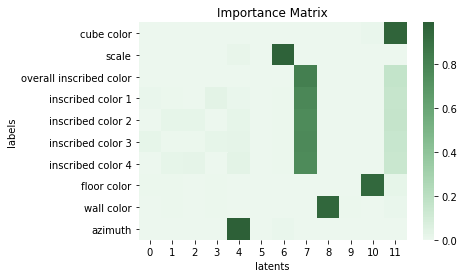

In [6]:
import numpy as np
import scipy
from sklearn import ensemble, preprocessing
import seaborn as sns
from multiprocessing import Pool

class DCI:
    def get_factor_gbt(self, factor):
        model = ensemble.GradientBoostingRegressor(verbose=0)
        model.fit(self.latents, self.labels[:,factor])
        importance_matrix_factor = np.abs(model.feature_importances_)
        return model, importance_matrix_factor
    
    def get_trained_gbts(self, latents, labels):
        self.latents, self.labels = latents, labels
        num_codes, num_factors = latents.shape[-1], labels.shape[-1]
        importance_matrix = np.zeros(shape=[num_codes, num_factors])
        models = []

        with Pool(10) as p: out = p.map(self.get_factor_gbt, list(range(num_factors)))

        for i,gbt_ret in enumerate(out):
            model, importance_matrix_factor = gbt_ret
            models.append(model)
            importance_matrix[:,i] = importance_matrix_factor
        return importance_matrix, models

def _compute_dci(mus_train, ys_train, mus_test, ys_test):
    """Computes score based on both training and testing codes and factors."""
    scores = {}
    importance_matrix, train_err, test_err = compute_importance_gbt(mus_train, ys_train, mus_test, ys_test)
    assert importance_matrix.shape[0] == mus_train.shape[0]
    assert importance_matrix.shape[1] == ys_train.shape[0]
    scores["informativeness_train"] = train_err
    scores["informativeness_test"] = test_err
    scores["disentanglement"] = disentanglement(importance_matrix)
    scores["completeness"] = completeness(importance_matrix)
    return scores



latents,labels,path=data
dci = DCI()
importance_matrix, models = dci.get_trained_gbts(latents, labels)

cmap = sns.cubehelix_palette(start=2, rot=0, dark=0.3, light=.95, reverse=False, as_cmap=True)
ax = sns.heatmap(np.transpose(importance_matrix), cmap=cmap, yticklabels=[
    "cube color", "scale", "overall inscribed color", 'inscribed color 1', 'inscribed color 2', 'inscribed color 3', 'inscribed color 4', 
    'floor color', 'wall color', 'azimuth'])
plt.title("Importance Matrix")
plt.xlabel("latents")
plt.ylabel("labels")
plt.show()    


In [21]:
def disentanglement_per_code(importance_matrix):
    """Compute disentanglement score of each code."""
    # importance_matrix is of shape [num_codes, num_factors].
    return 1. - scipy.stats.entropy(importance_matrix.T + 1e-11,
                                  base=importance_matrix.shape[1])

def disentanglement(importance_matrix):
    """Compute the disentanglement score of the representation."""
    per_code = disentanglement_per_code(importance_matrix)
    if importance_matrix.sum() == 0.:
        importance_matrix = np.ones_like(importance_matrix)
    code_importance = importance_matrix.sum(axis=1) / importance_matrix.sum()
    return np.sum(per_code*code_importance)

def completeness_per_factor(importance_matrix):
    """Compute completeness of each factor."""
    # importance_matrix is of shape [num_codes, num_factors].
    return 1. - scipy.stats.entropy(importance_matrix + 1e-11,
                                  base=importance_matrix.shape[0])

def completeness(importance_matrix):
    """"Compute completeness of the representation."""
    per_factor = completeness_per_factor(importance_matrix)
    if importance_matrix.sum() == 0.:
        importance_matrix = np.ones_like(importance_matrix)
    factor_importance = importance_matrix.sum(axis=0) / importance_matrix.sum()
    return np.sum(per_factor*factor_importance)

child_factors = [3,4,5,6]
parent_factor = [2]
overall_factors = [i for i in range(importance_matrix.shape[-1]) if not i in child_factors]
child_latents = np.max(importance_matrix[:,parent_factor+overall_factors],axis=-1)<=np.max(importance_matrix[:,child_factors],axis=-1)
overall_latents = np.logical_not(child_latents)
print("overall disentanglement: ",disentanglement(importance_matrix[overall_latents][:, overall_factors]))
print("child factor disentanglement: ",disentanglement(importance_matrix[child_latents][:, child_factors]))
#print("overall completeness: ",completeness(importance_matrix[overall_latents][:, overall_factors]))
print("child factor completeness: ",completeness(importance_matrix[child_latents][:, child_factors]))
# why completeness?
# - we want to know if information has been learned, 
#    - if the children isn't learned, then we need to make that clear
# - cons: completeness is affected by empty factors


[ True  True  True  True False False False False False False False False]
overall disentanglement:  0.8950490393463683
child factor disentanglement:  0.2446967248495983
child factor completeness:  0.250522208328541


[[0.00349072 0.00446738 0.00348294 0.00253018]
 [0.00253726 0.00299068 0.00314546 0.00452176]
 [0.0038208  0.01240278 0.00310175 0.01501225]
 [0.00279378 0.00501643 0.00388307 0.00299134]
 [0.00924536 0.00288954 0.00427396 0.0060907 ]
 [0.00305097 0.00348929 0.00279962 0.00482568]
 [0.00224116 0.00745117 0.00714807 0.00854   ]
 [0.00400879 0.00396305 0.00323062 0.00650551]
 [0.09670603 0.10073642 0.09721763 0.10221216]
 [0.12974663 0.08746617 0.12744675 0.07173068]
 [0.00604373 0.007476   0.00163659 0.00258739]
 [0.00182467 0.00235636 0.00462646 0.00410964]]
overall_disentanglement:  0.7274712511867724
child_disentanglement:  0.0
child_completeness:  0.0
['experiments', 'betavae_larger2', 'hiershapes', 'boxheadsimple', 'base', 'num_latents_12', 'beta_1_annealed', 'random_seed_30']


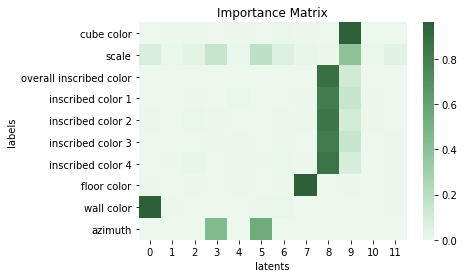

In [7]:
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt
from metrics import disentanglement, completeness
# get results:
def get_results():
    data = np.load("results_dci.npz", allow_pickle=True)
    paths = data["path"]
    modelspecs = np.asarray([path.rstrip("/mutual_info_sample/final.npz").split(os.path.sep) for path in data["path"]])
    return data, modelspecs

rdata, model_specs = get_results()
modelnum = 1064
importance_matrix = np.transpose(rdata["importance_matrix"][modelnum])
overall_disentanglement = rdata["overall_disentanglement"][modelnum]
overall_completeness = rdata["overall_completeness"][modelnum]
child_disentanglement = rdata["child_disentanglement"][modelnum]

print((1-importance_matrix[:,[2]])*importance_matrix[:,3:7])


child_completeness = np.where(np.isnan(rdata["child_completeness"]), 0, rdata["child_completeness"])[modelnum]
print("overall_disentanglement: ", overall_disentanglement)
#print("overall_completeness: ", overall_completeness)
print("child_disentanglement: ", child_disentanglement)
print("child_completeness: ", child_completeness)
print(model_specs[modelnum])

cmap = sns.cubehelix_palette(start=2, rot=0, dark=0.3, light=.95, reverse=False, as_cmap=True)
ax = sns.heatmap(np.transpose(importance_matrix), cmap=cmap, yticklabels=[
    "cube color", "scale", "overall inscribed color", 'inscribed color 1', 'inscribed color 2', 'inscribed color 3', 'inscribed color 4', 
    'floor color', 'wall color', 'azimuth'])
plt.title("Importance Matrix")
plt.xlabel("latents")
plt.ylabel("labels")
plt.show()    




In [1]:
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import pandas as pd
from metrics import disentanglement, completeness

def get_results():
    data = np.load("results_dci_with_elbo.npz", allow_pickle=True)
    paths = data["path"]
    modelspecs = np.asarray([path.rstrip("/run_set/sample.npz").split(os.path.sep)+[path] for path in data["path"]])
    return data, modelspecs

def get_scores(importance_matrix):
    child_factors = [3,4,5,6]
    parent_factor = [2]
    overall_factors = [i for i in range(importance_matrix.shape[-1]) if not i in child_factors]
    
    #child_latents = np.max(importance_matrix[:,overall_factors],axis=-1)<=np.max(importance_matrix[:,child_factors],axis=-1)
    #overall_latents = np.logical_not(child_latents)
    
    if sum(overall_factors)>2:
        overall_disentanglement = disentanglement(
            importance_matrix[overall_latents]#[:, overall_factors]
        )
        overall_completeness = completeness(
            importance_matrix[overall_latents]#[:, overall_factors]
        )
    else:
        overall_disentanglement = 0
        overall_completeness = 0

    if sum(child_latents)>2:
        child_disentanglement = disentanglement(
            importance_matrix[child_latents]#[:, child_factors]
        )
        child_completeness = completeness(
            importance_matrix[child_latents]#[:, child_factors]
        )
    else:
        child_disentanglement = 0
        child_completeness = 0
    return overall_disentanglement, overall_completeness, child_disentanglement, child_completeness


def format_data(modelspec, model_types, dataset_types):
    # get the model
    model = [i for i in model_types if i in modelspec]
    if not len(model): return None
    assert len(model) == 1, f"{len(model)}, {modelspec}"
    model = model[0]
    
    # get dataset
    dataset = [i for i in dataset_types if i in modelspec]
    if not len(dataset): return None
    assert len(dataset) == 1, f"{len(dataset)}, {modelspec}"
    dataset = dataset[0]
    
    # beta values
    beta = [i for i in modelspec if "beta_" in i][0]
    
    # gamma values
    gamma = [i for i in modelspec if "gamma_" in i]
    gamma = np.nan if not len(gamma) else gamma[0]
    
    # random seeds
    random_seed = [i for i in modelspec if "random_seed_" in i]
    
    path = modelspec[-1]
    
    # add to data
    return {"Model":model, "beta":beta, "gamma":gamma, "Dataset":dataset, "random seed": random_seed, "path":path}




def get_data(data, modelspecs, dataset_types, model_types, use_default_scores=False):
    dataframe = pd.DataFrame()
    
    if use_default_scores:
        overall_disentanglement_scores = data["overall_disentanglement"]
        overall_completeness_scores = data["overall_completeness"]
        child_disentanglement_scores = data["child_disentanglement"]
        elbo_losses = data["elbo_loss"]
        child_completeness_scores = np.where(np.isnan(data["child_completeness"]), 0, data["child_completeness"])
    
    for modelnum in range(len(modelspecs)):
        modelspec, importance_matrix = modelspecs[modelnum], data["importance_matrix"][modelnum]
        # get scores by recalculation
        if not use_default_scores:
            overall_disentanglement, overall_completeness, child_disentanglement, child_completeness = get_scores(np.transpose(importance_matrix))
        else: # use default scores
            overall_disentanglement = overall_disentanglement_scores[modelnum]
            overall_completeness = overall_completeness_scores[modelnum]
            child_disentanglement = child_disentanglement_scores[modelnum]
            child_completeness = child_completeness_scores[modelnum]
        elbo_loss = elbo_losses[modelnum]
        data_record = format_data(modelspec=modelspec, model_types=model_types, dataset_types=dataset_types)
        if data_record is None: continue
        data_record.update({
            "overall_disentanglement":overall_disentanglement, 
            "overall_completeness":overall_completeness, 
            "child_disentanglement":child_disentanglement, 
            "child_completeness":child_completeness,
            "combined_child":child_disentanglement*child_completeness,
            "elbo_loss":elbo_loss,
            "elbo":-elbo_loss
        })
        dataframe = dataframe.append(data_record, ignore_index=True)
    return dataframe



model_types = ["betavae","betatcvae","vlae","lvae"]+["betavae_larger2","betatcvae_larger2","vlae_larger2","lvae_larger2"]
#model_types = ["betavae","betavae_larger2","betatcvae","betatcvae_larger2","vlae","vlae_larger2","lvae","lvae_larger2"]
dataset_types = ["boxhead_07", "boxheadsimple", "boxheadsimple2"]
results, modelspecs = get_results()
data = get_data(data=results, modelspecs=modelspecs, dataset_types=dataset_types, model_types=model_types, use_default_scores=True)

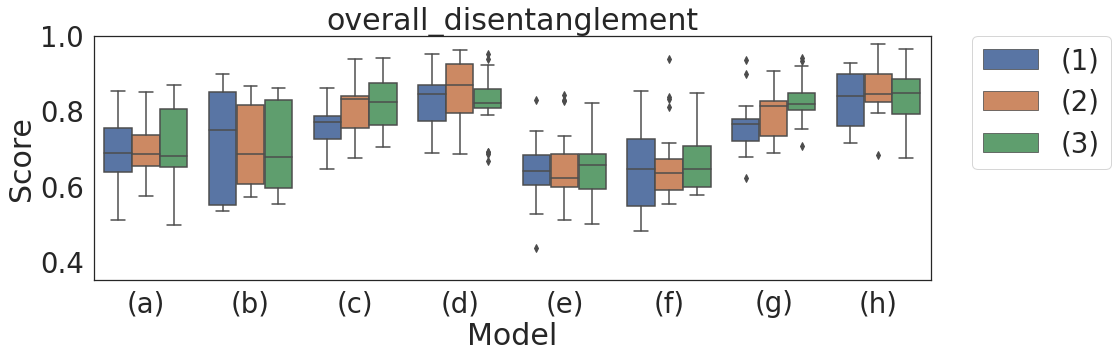

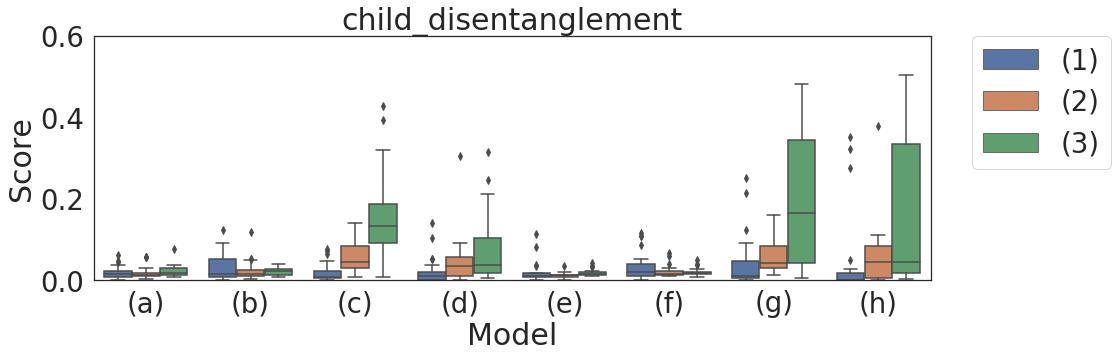

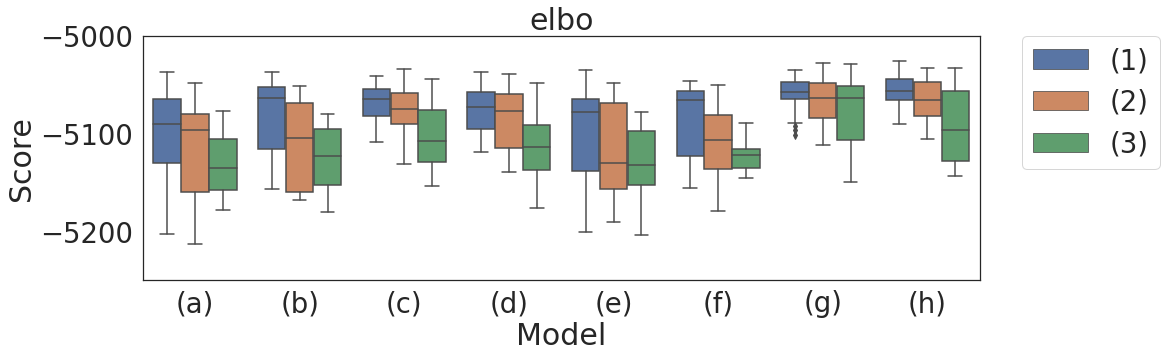

In [2]:
cur_data = data

cur_data = cur_data.loc[
    False
    |pd.isna(cur_data["gamma"])
    |(cur_data["gamma"]=="gamma_1")
    #|(cur_data["gamma"]=="gamma_5")
]

# get single layer beta models and ladder models
# cur_data = cur_data.loc[
#     False
#     |(data["beta"]=="beta_1_annealed")&(np.logical_not(cur_data["Model"].str.contains("beta")))
#     |(cur_data["beta"]=="beta_5_annealed")&(np.logical_not(cur_data["Model"].str.contains("beta")))
#     |(cur_data["beta"]=="beta_10_annealed")&(np.logical_not(cur_data["Model"].str.contains("beta")))
#     |(cur_data["beta"]=="beta_20_annealed")&(np.logical_not(cur_data["Model"].str.contains("beta")))
#     |(data["beta"]=="beta_1")&(cur_data["Model"].str.contains("beta"))
#     |(cur_data["beta"]=="beta_5")&(cur_data["Model"].str.contains("beta"))
#     |(cur_data["beta"]=="beta_10")&(cur_data["Model"].str.contains("beta"))
#     |(cur_data["beta"]=="beta_20")&(cur_data["Model"].str.contains("beta"))
# ]

cur_data = cur_data.loc[
    False
    |(cur_data["beta"]=="beta_1_annealed")
    |(cur_data["beta"]=="beta_5_annealed")
    |(cur_data["beta"]=="beta_10_annealed")
    |(cur_data["beta"]=="beta_20_annealed")
]

cur_data = cur_data.loc[
    False
    |(cur_data["Dataset"]=="boxhead_07")
    |(cur_data["Dataset"]=="boxheadsimple")
    |(cur_data["Dataset"]=="boxheadsimple2")
]
score_types = [
    "overall_disentanglement", 
    #"overall_completeness", 
    #"child_completeness",
    "child_disentanglement", 
    #"combined_child",
    "elbo"
]



# get top n values given a column for each model.
# new_data = []
# for model in model_types:
#        new_data.append(cur_data.loc[cur_data["Model"]==model].sort_values(by=['overall_disentanglement'])[-1:])
# new_data = pd.concat(new_data)
# print(new_data)


new_dataset_types = ["boxhead 1", "boxhead 2", "boxhead 3"]


reference_labels = {
    "boxhead 1":"(1)",
    "boxhead 2":"(2)", 
    "boxhead 3":"(3)",
    
    "betavae":"(a)",
    "betatcvae":"(b)",
    "vlae":"(c)",
    "lvae":"(d)",
    "betavae_larger2":"(e)",
    "betatcvae_larger2":"(f)",
    "vlae_larger2":"(g)",
    "lvae_larger2":"(h)",
}


#data if beta_vals is None else data.loc[data["beta"]==beta_vals]
plt.rcParams["figure.figsize"]=15,4.5
sns.set(font_scale = 2.5, style="white")
for score in score_types:
    plt.clf()
    plt.title(score)
    plot_data = cur_data.replace({"boxhead_07":"boxhead 1", "boxheadsimple":"boxhead 2","boxheadsimple2":"boxhead 3"})
    sns.boxplot(x='Model', y=score, hue="Dataset", order=[reference_labels[i] for i in model_types], hue_order=[reference_labels[i] for i in new_dataset_types],
                   data=plot_data.replace(reference_labels), 
                   #data=cur_data, 
                   #bw=.2, 
                   #cut=0, 
                   #inner="stick"
                  )
#     sns.boxplot(x='Dataset', y=score, hue="Model", order=new_dataset_types, hue_order=model_types,
#                data=cur_data.replace({"boxhead_07":"boxhead 1", "boxheadsimple":"boxhead 2","boxheadsimple2":"boxhead 3"}), 
#                #data=cur_data, 
#                #bw=.2, 
#                #cut=0, 
#                #inner="stick"
#               )
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    if score == "child_disentanglement":
        plt.ylim(0,0.6)
    if score == "overall_disentanglement":
        plt.ylim(0.35,1)
    if score == "elbo":
        plt.ylim(-5250,-5000)    
    
    plt.ylabel("Score")
    #plt.savefig(os.path.join("dev_paper", "images", score.replace(" ","_")+"_above_beta_1"+".png"))
    plt.show()



# # Compute the correlation matrix
# corr = cur_data.loc[:,["child_disentanglement", "overall_disentanglement", "elbo"]].corr()
# mask = np.triu(np.ones_like(corr, dtype=bool))
# f, ax = plt.subplots(figsize=(5, 5))
# cmap = sns.diverging_palette(230, 20, as_cmap=True)
# sns.heatmap(corr, 
#             mask=mask, 
#             cmap=cmap, center=0,
#             square=True, linewidths=.5, cbar_kws={"shrink": .5},
#             vmax=.5, vmin=-0.5,)
# plt.show()

In [14]:
from IPython.display import Image
from hsr.visualize import lvae_traversal, vlae_traversal
from hsr.save import ModelSaver
import metrics as mt
# correlation plots between various models for disentanglement scores
new_data = []
print(cur_data.columns)
print(cur_data.Dataset.unique())

def retrieve_model(path):
    modelsaver = ModelSaver(path)
    model = modelsaver.load()
    assert not model is None, f"No model found in {path}"
    return model
all_paths = mt.get_model_paths()
for model_type in model_types[2:]:
    print(model_type)
    model_data = cur_data.loc[cur_data["Model"]==model_type][score_types+["path"]]
    model_data.sort_values(by=["child_disentanglement"])
    path = model_data.iloc[-1]["path"]
    base_path = os.path.join("experiments",path.split("/hsr/results/")[1].rstrip("run_set/sample.npz"))# hard coded!
    image_path = os.path.join(base_path,"images","200000.gif")
    model_path = os.path.join(path.rstrip("run_set/sample.npz").replace("/results/","/models/"), "model")
    #model = retrieve_model(model_path)
    #dataset = mt.get_dataset(base_path)
#     image = dataset.preprocess(dataset.train(64).__iter__().__next__()[0][0:1])
    print(base_path)

#     num_steps = 5
#     if not "lvae" in model_type:
#         traversal = vlae_traversal(model,image,num_steps=num_steps)
#     else:
#         traversal = lvae_traversal(model,image,num_steps=num_steps)
#     plt.imshow(traversal)
#     plt.axis('off')
#     plt.savefig(os.path.join("/home/ychen/",model_type+"_traversal.png"), bbox_inches='tight', dpi=700)
    
#     #with open(path,'rb') as f:
#     #    display(Image(data=f.read(), format='png'))
    

Index(['Dataset', 'Model', 'beta', 'child_completeness',
       'child_disentanglement', 'combined_child', 'elbo', 'elbo_loss', 'gamma',
       'overall_completeness', 'overall_disentanglement', 'path',
       'random seed'],
      dtype='object')
['boxhead_07' 'boxheadsimple' 'boxheadsimple2']
vlae
experiments/vlae/hiershapes/boxheadsimple2/base/num_latents_4/beta_1_annealed/alpha_scheduled/random_seed_30
lvae
experiments/lvae/hiershapes/boxheadsimple2/base/num_latents_4/beta_1_annealed/alpha_scheduled/random_seed_30
betavae_larger2
experiments/betavae_larger2/hiershapes/boxheadsimple2/base/num_latents_12/beta_1_annealed/random_seed_30
betatcvae_larger2
experiments/betatcvae_larger2/hiershapes/boxheadsimple2/base/num_latents_12/beta_1_annealed/random_seed_30
vlae_larger2
experiments/vlae_larger2/hiershapes/boxheadsimple2/base/num_latents_4/base/gamma_1/beta_1_annealed/alpha_scheduled/random_seed_30
lvae_larger2
experiments/lvae_larger2/hiershapes/boxheadsimple2/base/num_latents_4/base